In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler


In [34]:
df = pd.read_csv('GE (1).csv')

In [35]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-01,8.96,9.04,8.51,8.61,8.552462,68778600
1,2019-10-02,8.56,8.62,8.41,8.51,8.453130,47520800
2,2019-10-03,8.50,8.71,8.25,8.71,8.651793,58626600
3,2019-10-04,8.61,8.70,8.54,8.57,8.512730,52272800
4,2019-10-07,8.55,8.65,8.48,8.56,8.502796,32170400


In [36]:
#Considering only 5 columns and removing volume column
cols = list(df)[1:6]
df_train = df[cols].astype(float)

In [37]:
training_dates = pd.to_datetime(df['Date'])

In [38]:
#Normalizing the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_train)
df_train_scaled = scaler.transform(df_train)

In [39]:
df_train.shape

(253, 5)

In [40]:
trainX = []
trainY = []

# Number of days we want to predict into the future
n_future = 1

# Number of past days we want to use to predict the future
n_past = 14     

for i in range(n_past, len(df_train_scaled) - n_future +1):
    trainX.append(df_train_scaled[i - n_past:i, 0:df_train.shape[1]])
    trainY.append(df_train_scaled[i + n_future - 1:i + n_future, 0])

In [41]:
#converting to numpy array to give it as input to LSTM Model
trainX, trainY = np.array(trainX), np.array(trainY)

In [42]:
trainX.shape

(239, 14, 5)

In [43]:
trainY.shape

(239, 1)

In [44]:
#Defining Model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

In [45]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 14, 64)            17920     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [46]:
# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
14/14 [==============================] - 4s 256ms/step - loss: 0.4965 - val_loss: 0.1280
Epoch 2/10
14/14 [==============================] - 2s 165ms/step - loss: 0.1635 - val_loss: 0.0258
Epoch 3/10
14/14 [==============================] - 3s 188ms/step - loss: 0.1108 - val_loss: 0.0241
Epoch 4/10
14/14 [==============================] - 2s 147ms/step - loss: 0.0885 - val_loss: 0.0122
Epoch 5/10
14/14 [==============================] - 2s 161ms/step - loss: 0.0988 - val_loss: 0.0218
Epoch 6/10
14/14 [==============================] - 2s 156ms/step - loss: 0.0685 - val_loss: 0.0123
Epoch 7/10
14/14 [==============================] - 2s 136ms/step - loss: 0.0694 - val_loss: 0.0150
Epoch 8/10
14/14 [==============================] - 2s 138ms/step - loss: 0.0671 - val_loss: 0.0188
Epoch 9/10
14/14 [==============================] - 3s 197ms/step - loss: 0.0568 - val_loss: 0.0210
Epoch 10/10
14/14 [==============================] - 2s 156ms/step - loss: 0.0615 - val_loss: 0.0111

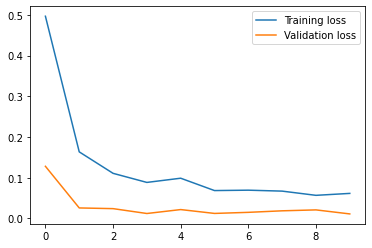

In [47]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [48]:
#Predicting the future (next 3 months) by starting from the last date of training dataset
n_future=90 
forecast_period_dates = pd.date_range(list(training_dates)[-1], periods=n_future, freq='1d').tolist()
forecast = model.predict(trainX[-n_future:]) #forecast 

In [49]:
#inverse transformation to rescale it back to the original range
forecast_copies = np.repeat(forecast, df_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [50]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

C:\Users\Jesh\anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='Date', ylabel='Open'>

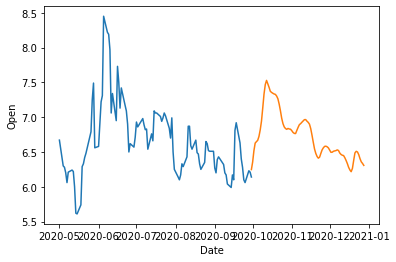

In [51]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])